In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
from keras.datasets import cifar10

mpl.rcParams['figure.figsize'] = (8, 8)
mpl.rcParams['axes.grid'] = False

Using TensorFlow backend.


In [2]:
# The data, split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [3]:
pretrained_model = tf.keras.applications.MobileNetV2(include_top=True,
                                                     weights='imagenet')
pretrained_model.trainable = False

# ImageNet labels
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

In [4]:
# Helper function to preprocess the image so that it can be inputted in MobileNetV2
def preprocess(image):
    image = tf.cast(image, tf.float32)
    image = image/255
    image = tf.image.resize(image, (224, 224))
    image = image[None, ...]
    return image

# Helper function to extract labels from probability vector
def get_imagenet_label(probs):
    return decode_predictions(probs, top=1)[0][0]

In [5]:
def process_cifar_set(dataset):
    res = []
    for image in dataset:
        res.append(preprocess(image))
    res = tf.concat(res, axis=0)
    return res

In [6]:
#data_tensor = process_cifar_set(x_train[:100])

In [7]:
image_path = 'elephant.jpg'
image_raw = tf.io.read_file(image_path)
image = tf.image.decode_image(image_raw)

In [8]:
image = preprocess(image)
image

<tf.Tensor: id=6427, shape=(1, 224, 224, 3), dtype=float32, numpy=
array([[[[0.7539566 , 0.7814076 , 0.8441527 ],
         [0.7629466 , 0.7903976 , 0.8531427 ],
         [0.7641255 , 0.7915765 , 0.8543216 ],
         ...,
         [0.78436315, 0.81489295, 0.8851861 ],
         [0.7330618 , 0.78328973, 0.8523634 ],
         [0.71288204, 0.75994086, 0.84849167]],

        [[0.74030113, 0.7677521 , 0.83834034],
         [0.744336  , 0.771787  , 0.8423752 ],
         [0.74559623, 0.7730472 , 0.8357923 ],
         ...,
         [0.8322126 , 0.85957766, 0.92017734],
         [0.79802996, 0.83157337, 0.8973647 ],
         [0.72635597, 0.7703773 , 0.85057676]],

        [[0.72860384, 0.7560548 , 0.82664305],
         [0.7317227 , 0.7591737 , 0.8297619 ],
         [0.72780114, 0.7552521 , 0.82584035],
         ...,
         [0.8705224 , 0.8940518 , 0.9421527 ],
         [0.84888744, 0.87241685, 0.9273188 ],
         [0.75327265, 0.7880596 , 0.8637075 ]],

        ...,

        [[0.46919492, 0.3

In [9]:
image_probs = pretrained_model.predict(image)

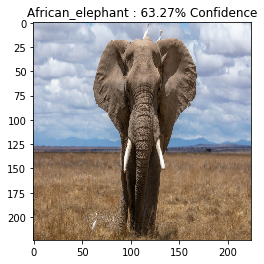

In [10]:
plt.figure()
plt.imshow(image[0])
_, image_class, class_confidence = get_imagenet_label(image_probs)
plt.title('{} : {:.2f}% Confidence'.format(image_class, class_confidence*100))
plt.show()

In [11]:
loss_object = tf.keras.losses.CategoricalCrossentropy()

def create_adversarial_pattern(input_image, input_label):
    with tf.GradientTape() as tape:
        tape.watch(input_image)
        prediction = pretrained_model(input_image)
        loss = loss_object(input_label, prediction)

    # Get the gradients of the loss w.r.t to the input image.
    gradient = tape.gradient(loss, input_image)
    # Get the sign of the gradients to create the perturbation
    signed_grad = tf.sign(gradient)
    return signed_grad

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


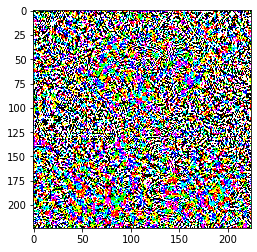

In [12]:
# Get the input label of the image.
labrador_retriever_index = 208
label = tf.one_hot(labrador_retriever_index, image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))

perturbations = create_adversarial_pattern(image, label)
plt.imshow(perturbations[0])

In [13]:
def display_images(image, description):
    _, label, confidence = get_imagenet_label(pretrained_model.predict(image))
    plt.figure()
    plt.imshow(image[0])
    plt.title('{} \n {} : {:.2f}% Confidence'.format(description,
                                                   label, confidence*100))
    plt.show()

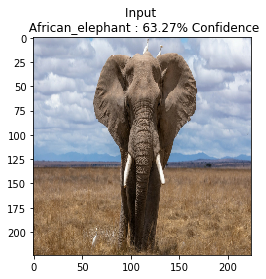

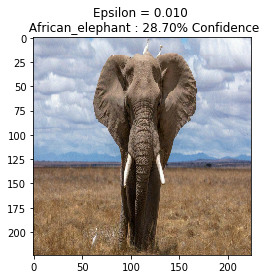

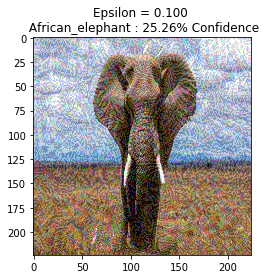

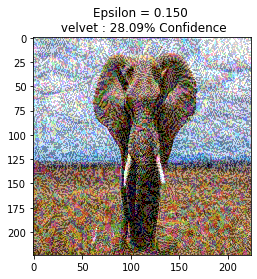

In [14]:
epsilons = [0, 0.01, 0.1, 0.15]
descriptions = [('Epsilon = {:0.3f}'.format(eps) if eps else 'Input')
                for eps in epsilons]

for i, eps in enumerate(epsilons):
    adv_x = image + eps*perturbations
    adv_x = tf.clip_by_value(adv_x, 0, 1)
    display_images(adv_x, descriptions[i])